# X-ray challenge

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd ./drive/MyDrive/raw_data



/content/drive/MyDrive/raw_data


In [3]:
%ls


bacterial_pneumonia/  covid-19/  normal/  viral_pneumonia/


In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib.pyplot import imread
import pathlib

In [5]:
print(tf.__version__)

2.4.1


In [6]:

#data_dir = pathlib.Path(dataset_path)

In [7]:
dataset_path = "/content/drive/MyDrive/trainset "

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224), # TRANFER LEARNING MODEL VGG16 DEMAND S SIZE OF 224, 224 
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 4253 files for training.


In [9]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 1063 files for validation.


In [11]:
val_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
class_names = train_ds.class_names
print(class_names)

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [14]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
val_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [16]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0014705884 0.99819684


In [18]:
normalized_train_ds

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [19]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_val_ds))
first_image_val = image_batch_val[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_val), np.max(first_image_val)) 

0.00027508952 0.99957985


In [20]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
   model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape) 
   return model

In [22]:
num_classes = 4

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(
  optimizer='adam',
  loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [25]:
history = model.fit(normalized_train_ds,
          batch_size=32,
          epochs=100,
          validation_data=normalized_val_ds,
          callbacks=[es])

Epoch 1/100
133/133 [==============================] - 1084s 8s/step - loss: 1.3382 - accuracy: 0.3819 - val_loss: 1.3513 - val_accuracy: 0.3857
Epoch 2/100
133/133 [==============================] - 64s 460ms/step - loss: 1.2687 - accuracy: 0.4287 - val_loss: 0.7200 - val_accuracy: 0.7065
Epoch 3/100
133/133 [==============================] - 62s 450ms/step - loss: 0.6516 - accuracy: 0.7304 - val_loss: 0.6282 - val_accuracy: 0.7394
Epoch 4/100
133/133 [==============================] - 61s 441ms/step - loss: 0.5834 - accuracy: 0.7645 - val_loss: 0.6359 - val_accuracy: 0.7366
Epoch 5/100
133/133 [==============================] - 62s 448ms/step - loss: 0.5366 - accuracy: 0.7763 - val_loss: 0.5779 - val_accuracy: 0.7686
Epoch 6/100
133/133 [==============================] - 60s 438ms/step - loss: 0.5366 - accuracy: 0.7645 - val_loss: 0.5656 - val_accuracy: 0.7742
Epoch 7/100
133/133 [==============================] - 61s 441ms/step - loss: 0.5116 - accuracy: 0.7774 - val_loss: 0.5812 - 

In [28]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

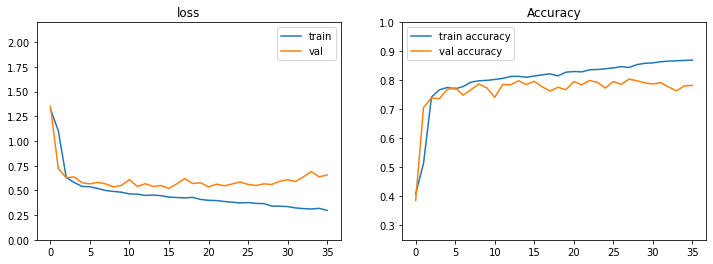

In [30]:
import matplotlib.pyplot as plt

plot_history(history)
plt.show()

In [31]:
from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, '/content/drive/MyDrive/models/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/my_model/assets


In [ ]:
# and you can load it somewhere else :
#loaded_model = models.load_model('my_model')

In [ ]:
#res = model.evaluate(X_test, y_test, verbose=0)

#print(f'The accuracy is of {res[1]*100:.3f}% compared to a chance level of {1./len(labels)*100} %')